In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# print(tf.__version__)

In [22]:
tf.__version__

'2.3.0'

<h3>Download the movie review dataset(binary-classification)</h3>

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84131840/84125825 [==============================] - 3s 0us/step


In [3]:
dataset_dir

'.\\aclImdb'

In [5]:
os.path.dirname(dataset)

'.'

In [4]:
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [6]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [7]:
sample_file = os.path.join(train_dir, 'neg/1_1.txt')

In [8]:
with open(sample_file) as f:
    print(f.read())

Robert DeNiro plays the most unbelievably intelligent illiterate of all time. This movie is so wasteful of talent, it is truly disgusting. The script is unbelievable. The dialog is unbelievable. Jane Fonda's character is a caricature of herself, and not a funny one. The movie moves at a snail's pace, is photographed in an ill-advised manner, and is insufferably preachy. It also plugs in every cliche in the book. Swoozie Kurtz is excellent in a supporting role, but so what?<br /><br />Equally annoying is this new IMDB rule of requiring ten lines for every review. When a movie is this worthless, it doesn't require ten lines of text to let other readers know that it is a waste of time and tape. Avoid this movie.


<h3>Load the dataset</h3>
main_directory/<br>
...class_a/<br>
......a_text_1.txt<br>
......a_text_2.txt<br>
...class_b/<br>
......b_text_1.txt<br>
......b_text_2.txt<br>

In [10]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [11]:
train_dir

'.\\aclImdb\\train'

In [12]:
batch_size = 32
seed = 2020

raw_train_data = tf.keras.preprocessing.text_dataset_from_directory(
    #'aclImdb/train'
    train_dir,
    batch_size = batch_size,
    validation_split = 0.2,
    subset = 'training',
    seed = seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [17]:
for text_batch, label_batch in raw_train_data.take(1):
    for i in range(4):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b"I am not a parent, neither am I a male. But I was able to identify with every character's heartaches and pains.<br /><br />This is a movie teenagers should watch. Maybe that way they will start appreciating the value of family again. I'm sorry for those that don't understand the value of love, family and friendship.<br /><br />It was very interesting to watch Patrick Duffy in a different role than that of Bobby Ewing. And it is great to see a 19 year old Ben Affleck giving his best in a moving and sincere performance. He showed at an early age, that he is capable of heartfelt drama. He should be offered more serious roles. Note Hollywoodland... his first serious role in years and he went out and won Best Actor at the Venice Festival in 2006.<br /><br />This movie can be appreciated by people of all ages. Maybe shouldn't be watched by children under 10 because they might get scared that the same may happen to their families, but I recommend it to the entire family.<br /><br />I

In [43]:
for x in raw_train_data.take(1):
    print(x)

(<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b"This is one of those feel good, Saturday afternoon movies. It's right up there with other retro flicks like Flight of the Navigator. Just a cute movie with some subtle comedy to lighten things up. And it's fun to see how 20 years has changed the stars like Kelly Preston and Lea Thompson. Not to mention Joquin Phoenix.<br /><br />I personally really like movies like this from time to time. Nothing too deep or too scary. Just a nice story line. And I would have never known Mr. Phoenix had I not recently read the credits. He was just a baby really when he made this movie.<br /><br />Kelly Preston was quite the young budding actress then too. She and Lea did a wonderful job in this movie. I agree it's not an Oscar caliber movie. But very much worth watching. Especially if you have kids in the , let's say, 8 to 11 year old range. Or ones that are interested in the space program.",
       b"Predictable parody, just about failed to impre

In [30]:
raw_train_data.__dict__

{'_input_dataset': <ShuffleDataset shapes: ((), ()), types: (tf.string, tf.int32)>,
 '_batch_size': <tf.Tensor: shape=(), dtype=int64, numpy=32>,
 '_drop_remainder': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 '_structure': (TensorSpec(shape=(None,), dtype=tf.string, name=None),
  TensorSpec(shape=(None,), dtype=tf.int32, name=None)),
 '_variant_tensor_attr': <tf.Tensor: shape=(), dtype=variant, numpy=<unprintable>>,
 '_self_setattr_tracking': True,
 '_self_unconditional_checkpoint_dependencies': [TrackableReference(name='_variant_tracker', ref=<tensorflow.python.data.ops.dataset_ops._VariantTracker object at 0x00000263620DC8B0>)],
 '_self_unconditional_dependency_names': {'_variant_tracker': <tensorflow.python.data.ops.dataset_ops._VariantTracker at 0x263620dc8b0>},
 '_self_unconditional_deferred_dependencies': {},
 '_self_update_uid': -1,
 '_self_name_based_restores': set(),
 '_self_saveable_object_factories': {},
 '_variant_tracker': <tensorflow.python.data.ops.dataset_ops._Var

<h4>0 or 1: which one stands for positive sentiment?</h4>

In [48]:
print("Label 0 corresponds to ", raw_train_data.class_names[0])
print("Label 1 corresponds to ", raw_train_data.class_names[1])

Label 0 corresponds to  neg
Label 1 corresponds to  pos


In [19]:
raw_validate_data = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [20]:
test_dir = os.path.join(dataset_dir, 'test')
os.listdir(test_dir)

['labeledBow.feat', 'neg', 'pos', 'urls_neg.txt', 'urls_pos.txt']

In [21]:
raw_test_data = tf.keras.preprocessing.text_dataset_from_directory(
    test_dir, 
    batch_size = batch_size)

Found 25000 files belonging to 2 classes.


In [50]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

In [51]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

<pre>Make a text-only dataset (without labels), 
then call adapt to fit the state of the preprocessing layer to the dataset</pre>

In [52]:
train_text = raw_train_data.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [53]:
type(vectorize_layer)

tensorflow.python.keras.layers.preprocessing.text_vectorization.TextVectorization

In [54]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label 

<pre>retrieve a batch (of 32 reviews and labels) from the dataset</pre>

In [56]:
text_batch, label_batch = next(iter(raw_train_data))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_data.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'WAR, INC. (2008) **1/2 John Cusack, Marisa Tomei, Hilary Duff, Joan Cusack, Ben Kingsley, Dan Aykroyd, Sergej Trifunovic, Lyubomir Neikov, Ned Bellamy, (Voice of: Montel Williams)<br /><br />A hit-and-miss-21st Century "STRANGELOVE"<br /><br />John Cusack \xc2\x96 who co-wrote the script with Mark Leyner and Jeremy Pikser \xc2\x96 stars as a jaded hit-man named Brand Hauser who is burnt out but decides to follow thru on one final assignment by icing a Middle-Eastern oil minister named Omar Sharif (yes, not THAT Omar Sharif but you get the tone here from this misfire for a laugh) commandeered by the ex-Vice President of The USA (Aykroyd, Cusack\'s old "Grosse Pointe Blank" co-hort, doing a mean Dick Cheney manqu\xc3\xa9 turn here), enlisting Brand to do the deed under the guise of a Trade Show Producer in mythical Turaqistan (read: Iraq/Afghanistan) for the American private corporation Tamerlane (read: Halliburton). <br /><br />While being briefed Brand is faced with 

<h4>Lookup the token (string) that each integer corresponds to.</h4>

In [62]:
print("1287 ---> ", vectorize_layer.get_vocabulary()[1287])
print(" 0 ---> ", vectorize_layer.get_vocabulary()[0])
print(" 1 ---> ", vectorize_layer.get_vocabulary()[1])
print(" 5582 ---> ",vectorize_layer.get_vocabulary()[5582])
print(" 321 ---> ",vectorize_layer.get_vocabulary()[321])
print(" 9118 ---> ",vectorize_layer.get_vocabulary()[9118])
print(" 9151 ---> ",vectorize_layer.get_vocabulary()[9151])
print(" 1701 ---> ",vectorize_layer.get_vocabulary()[1701])
print("Vocabulary size: {}".format(len(vectorize_layer.get_vocabulary())))

1287 --->  excuse
 0 --->  
 1 --->  [UNK]
 5582 --->  2008
 321 --->  war
 9118 --->  inc
 9151 --->  duff
 1701 --->  joan
Vocabulary size: 10000


In [63]:
train_data = raw_train_data.map(vectorize_text)
validate_data = raw_validate_data.map(vectorize_text)
test_data = raw_test_data.map(vectorize_text)

<h3>Configure the dataset for performance</h3>

<pre>
.cache() 
.prefetch()</pre>

In [64]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
validate_data = validate_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)


<h3>Model Definition</h3>

In [72]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [65]:
embedding_dim = 16

model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [66]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

<h3>Training</h3>

In [67]:
epochs = 10
history = model.fit(
    train_data,
    validation_data=validate_data,
    callbacks=[callback],
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 15s 24ms/step - loss: 0.6646 - binary_accuracy: 0.6896 - val_loss: 0.6158 - val_binary_accuracy: 0.7608
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 0.5490 - binary_accuracy: 0.7991 - val_loss: 0.4997 - val_binary_accuracy: 0.8188
Epoch 3/10
625/625 [==============================] - 2s 2ms/step - loss: 0.4447 - binary_accuracy: 0.8453 - val_loss: 0.4232 - val_binary_accuracy: 0.8422
Epoch 4/10
625/625 [==============================] - 2s 2ms/step - loss: 0.3767 - binary_accuracy: 0.8668 - val_loss: 0.3788 - val_binary_accuracy: 0.8530
Epoch 5/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3335 - binary_accuracy: 0.8795 - val_loss: 0.3519 - val_binary_accuracy: 0.8606
Epoch 6/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3028 - binary_accuracy: 0.8906 - val_loss: 0.3334 - val_binary_accuracy: 0.8674
Epoch 7/10
625/625 [==============================] - 1s 2ms/s

<h3>Evaluation</h3>

In [68]:
loss, accuracy = model.evaluate(test_data)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 15s 19ms/step - loss: 0.3125 - binary_accuracy: 0.8724
Loss:  0.3124772906303406
Accuracy:  0.8723999857902527


In [69]:
# model.fit() returns a history object that contains a dictionary with everything that happened during training:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

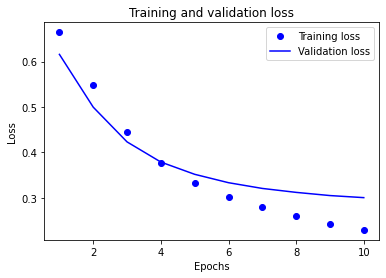

In [70]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

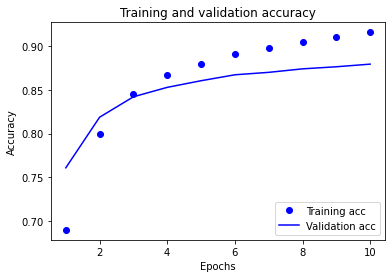

In [71]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

<h3>Export the Model</h3>

In [73]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_data`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_data)
print(accuracy)

782/782 [==============================] - 15s 20ms/step - loss: 0.3125 - accuracy: 0.8724
0.8723999857902527


<h4>Inference Mode</h4>

In [76]:
examples = [
  "What an amazing movie!",
  "The movie was great.",
  "The movie was terrible..."
]

export_model.predict(examples)

array([[0.5763417 ],
       [0.53943664],
       [0.28065485]], dtype=float32)